In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from tools.ldm import LdmExtractor
from diffcut.recursive_normalized_cut import DiffCut

from tools.pamr import PAMR
from scipy.ndimage import median_filter

0


In [2]:
def mask_refinement(labels, image):
    masks = torch.cat([1. * (labels == label) for label in torch.unique(labels)], dim=1)
    # num_iter and dilations impact final result
    labels = PAMR(num_iter=30, dilations=[1, 2, 4, 8, 12, 24, 32])(image, masks)

    labels = 1. * torch.argmax(labels, dim=1)
    labels = median_filter(labels.cpu().numpy(), 3).astype(int)

    return labels

#### __Load Diffusion Model__

In [3]:
extractor = LdmExtractor(model_name="SSD-1B")

Loading SD model


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

SD model loaded


#### __Diffusion Features Extraction__

In [4]:
img_path = "./assets/coco.jpg"

pil_img = Image.open(img_path).convert('RGB')
image = T.ToTensor()(pil_img).unsqueeze(0).to("cuda")
_, _, h, w = image.shape

# Input image is resized to img_size 
img_size = 1024 # 2048

# Denoising Timestep
t = 50

# Output features from the last self-attention block of the UNet encoder
features = extractor(image, step=t, img_size=img_size)

#### __Zero-Shot Image Segmentation with DiffCut__

In [5]:
# Hyperparameters
tau = 0.5
alpha = 10

# Recursive Feature Clustering
masks = DiffCut().generate_masks(features, tau=tau, mask_size=(h, w), alpha=alpha, img_size=img_size)
masks = torch.Tensor(masks).to("cuda")

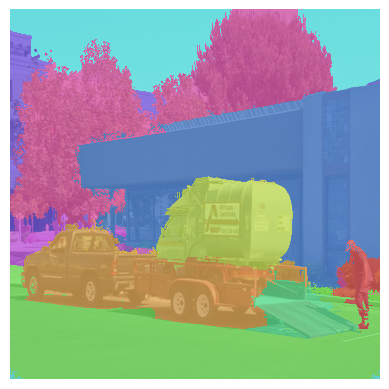

In [6]:
# Mask Refinement
image = F.interpolate(image, size=(img_size, img_size), mode='bilinear')
new_mask = mask_refinement(masks, image)

colors = sns.hls_palette(len(np.unique(new_mask)), h=0.9)
cmap = ListedColormap(colors)

plt.imshow(image.cpu()[0].permute(1, 2, 0))
plt.imshow(new_mask[0], cmap=cmap, interpolation='nearest', alpha=0.8)
plt.axis("off");